<a href="https://colab.research.google.com/github/sunny0103/DS_project/blob/main/Hospital%20readmission/hospital_readmissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission.

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

**Table of Contents**
1. Introduction
2. Executive Summary
3. Data
4. Expolaratory Data Analysis(EDA)
5. Further Consideration and visualization


## 1. Introduction
Hospital readmission poses a significant challenge in healthcare, both in terms of costs and patient well-being. This issue often arises due to factors such as insufficient care during the initial hospital stay and inadequate discharge planning. Patients with chronic illnesses, including heart failure, diabetes, and respiratory diseases, are especially vulnerable to being readmitted. Addressing this problem requires targeted interventions, such as better care coordination, comprehensive patient education, and effective medication management. Machine learning (ML) and artificial intelligence (AI) offer innovative solutions by predicting patients at high risk of readmission. These predictions enable healthcare providers to implement proactive measures, ultimately reducing readmission rates and improving patient outcomes.

## 2. Executive Summary
Goal of this task is helping a hospital group to improve their understanding of patient readmission. By understanding their patients' readmission, they can take care more of their patients before they being discharced so that they can reduce the rate of readmission.

**The result**
1. The Primary disease diagnosis that is most frequently observed among different age group is Circulatory, except for the 40-50 age group, where Ohter is the most common diagnosis. The second and the third diagnosis are other and respiratory.
2. Patients who taking diabetes medicine have a higher readmission rate than those who are not taking diabetes medicine. The Chi-square staticstical test reveals that there was signigicant statistical association between primary diagnosis and hospital readmission rate.
3. The hospital should concentrate its efforts on patient groups:
    - Number of lab procedure
    - number of medication
    - times in hospital

- Patients who has higher number of inpatient are higher chance to readmission but  lower number of inpatient is less likely to readmitted to the hospital.
- The number of emergency and outpatient numbers are the same as inpatient feature explanation. Patients who often carries in emergency and visit the hospital as outpatient are more likely to be readmitted compared to those are not.
- On the other, number of medications feature can interpret opposite perspective. Those who often prescribe medicine are less likely to be readmitted than those who are not.

## 3. The data
(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008))
#### Information in the file
- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay
- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay
- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

In [206]:
pip install lightgbm

In [207]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
cd /content/drive/My Drive/Colab Notebooks/workspace

/content/drive/My Drive/Colab Notebooks/workspace


In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

from lightgbm import  LGBMClassifier
import lightgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
plt.style.use('ggplot')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
start_color = '#c5c8eb'
end_color = '#181e69'

# Generate a color gradient using numpy and matplotlib
n_colors = 10  # Number of gradient steps
colors = LinearSegmentedColormap.from_list("custom_gradient", [start_color, end_color])(np.linspace(0, 1, n_colors))

# Create a Seaborn color palette
palette = sns.color_palette(colors)

pallete_list = [start_color, end_color]

In [210]:
df = pd.read_csv('hospital_readmissions.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [211]:
print("Rows :{} \nColumns:{}".format(df.shape[0], df.shape[1]))

Rows :25000 
Columns:17


In [212]:
df.isnull().sum()

,0
age,0
time_in_hospital,0
n_lab_procedures,0
n_procedures,0
n_medications,0
n_outpatient,0
n_inpatient,0
n_emergency,0
medical_specialty,0
diag_1,0


In [213]:
print("Check the number of duplication of Data: {} ".format(df.duplicated().sum()))

Check the number of duplication of Data: 0 


The dataframe contains 25000 rows and 17 columns, with no missing vallues or duplication rows.

## 4. EDA
### 4.1. The most common primary diagnosis by age group

In [214]:
prim_diag_age = df.groupby(['diag_1', 'age'])['diag_1'].count().unstack()
prim_diag_age.drop('Missing', inplace=True)
prim_diag_age

age,[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
diag_1,,,,,,
Circulatory,504.0,1256.0,1962.0,2392.0,1482.0,228.0
Diabetes,369.0,393.0,385.0,385.0,181.0,34.0
Digestive,271.0,442.0,554.0,585.0,402.0,75.0
Injury,162.0,273.0,400.0,444.0,321.0,66.0
Musculoskeletal,100.0,230.0,373.0,373.0,168.0,8.0
Other,750.0,1164.0,1402.0,1693.0,1269.0,220.0
Respiratory,376.0,694.0,836.0,964.0,691.0,119.0


In [215]:
def plot_diagnosis(i, ax):
    ax = sns.barplot(y=prim_diag_age.iloc[i], x=prim_diag_age.columns, color=pallete_list[1])
    for p in ax.patches:
        ax.annotate(int(p.get_height()),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        xytext = (0, 10),
                        textcoords = 'offset points')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(str(prim_diag_age.iloc[i].name), fontsize = 12, x=0.5, y=1.1)

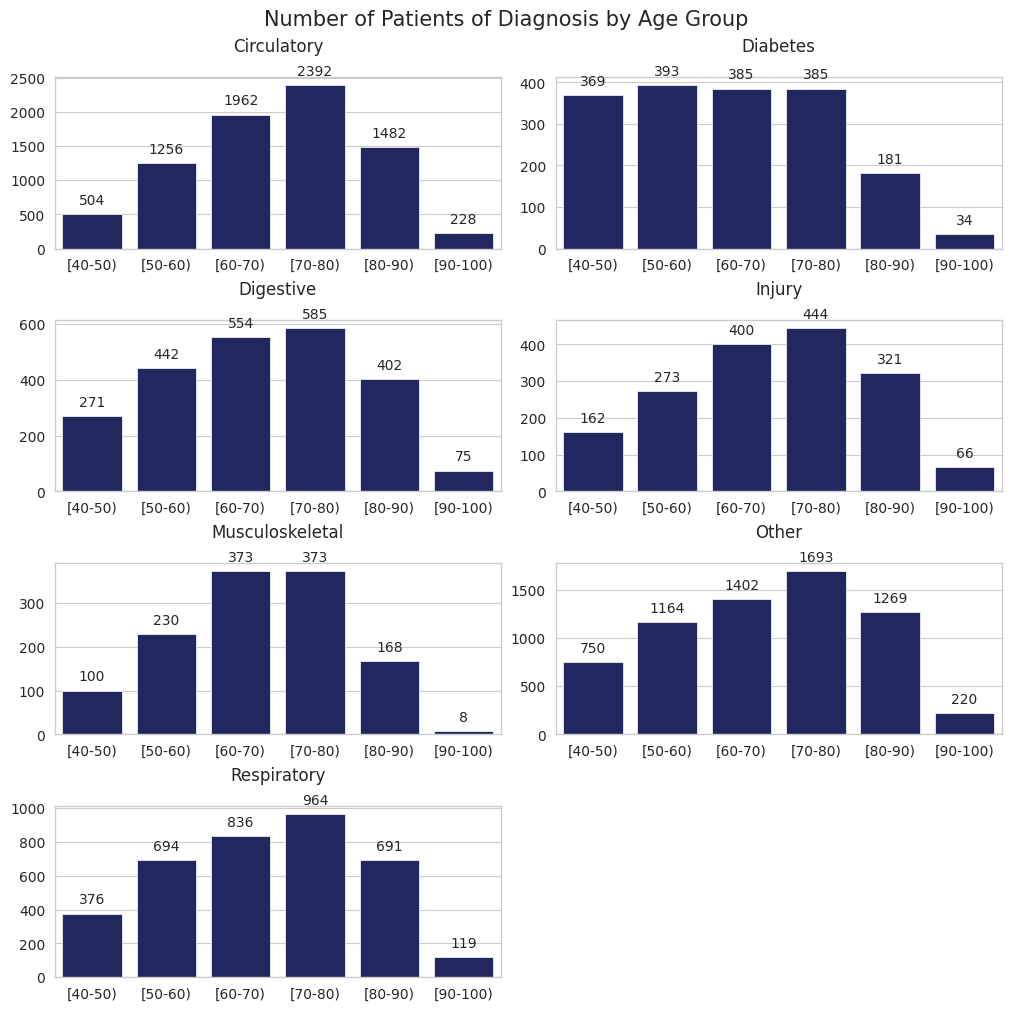

In [216]:
fig = plt.figure(layout="constrained", figsize=(10, 10))

ax1 = plt.subplot2grid((4, 2), (0, 0))
plot_diagnosis(0, ax1)
ax2= plt.subplot2grid((4, 2), (0, 1))
plot_diagnosis(1, ax2)
ax3 = plt.subplot2grid((4, 2), (1, 0))
plot_diagnosis(2, ax3)
ax4 = plt.subplot2grid((4, 2), (1, 1))
plot_diagnosis(3, ax4)
ax5 = plt.subplot2grid((4, 2), (2, 0))
plot_diagnosis(4, ax5)
ax6 = plt.subplot2grid((4, 2), (2, 1))
plot_diagnosis(5, ax6)
ax7 = plt.subplot2grid((4, 2), (3, 0), rowspan=2)
plot_diagnosis(6, ax7)

fig.suptitle('Number of Patients of Diagnosis by Age Group', fontsize=15)
plt.show()

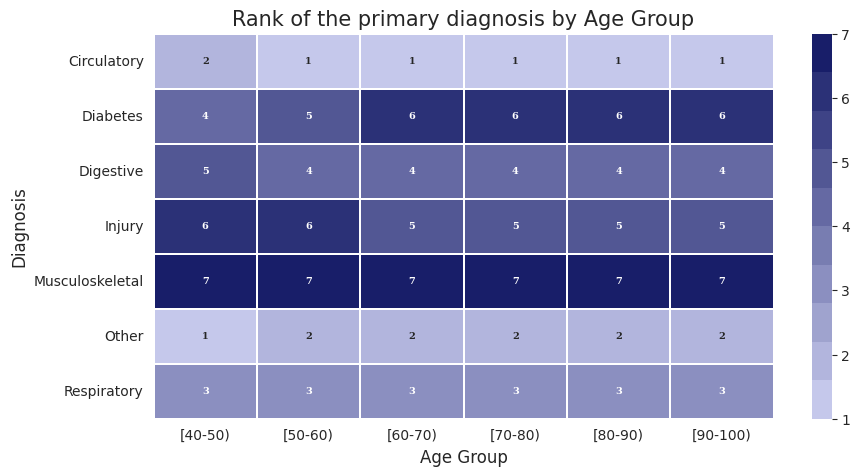

In [217]:
prim_diag_age_rank = prim_diag_age.rank(method='max', ascending=False, axis=0)
plt.figure(figsize=(10,5))
sns.heatmap(prim_diag_age_rank, cmap=palette, # blue colors
            annot=True, # annotate
            fmt=".0f", # annotation text type d: digit, f:float
            annot_kws={ # annotation detail change
                'fontsize': 7, # change font size
                'fontweight': 'bold',# bold type
                'fontfamily': 'serif'
            }, linewidths=0.02) # make some space between lines
plt.xlabel('Age Group')
plt.ylabel('Diagnosis')
plt.title('Rank of the primary diagnosis by Age Group', fontsize=15)
plt.show()

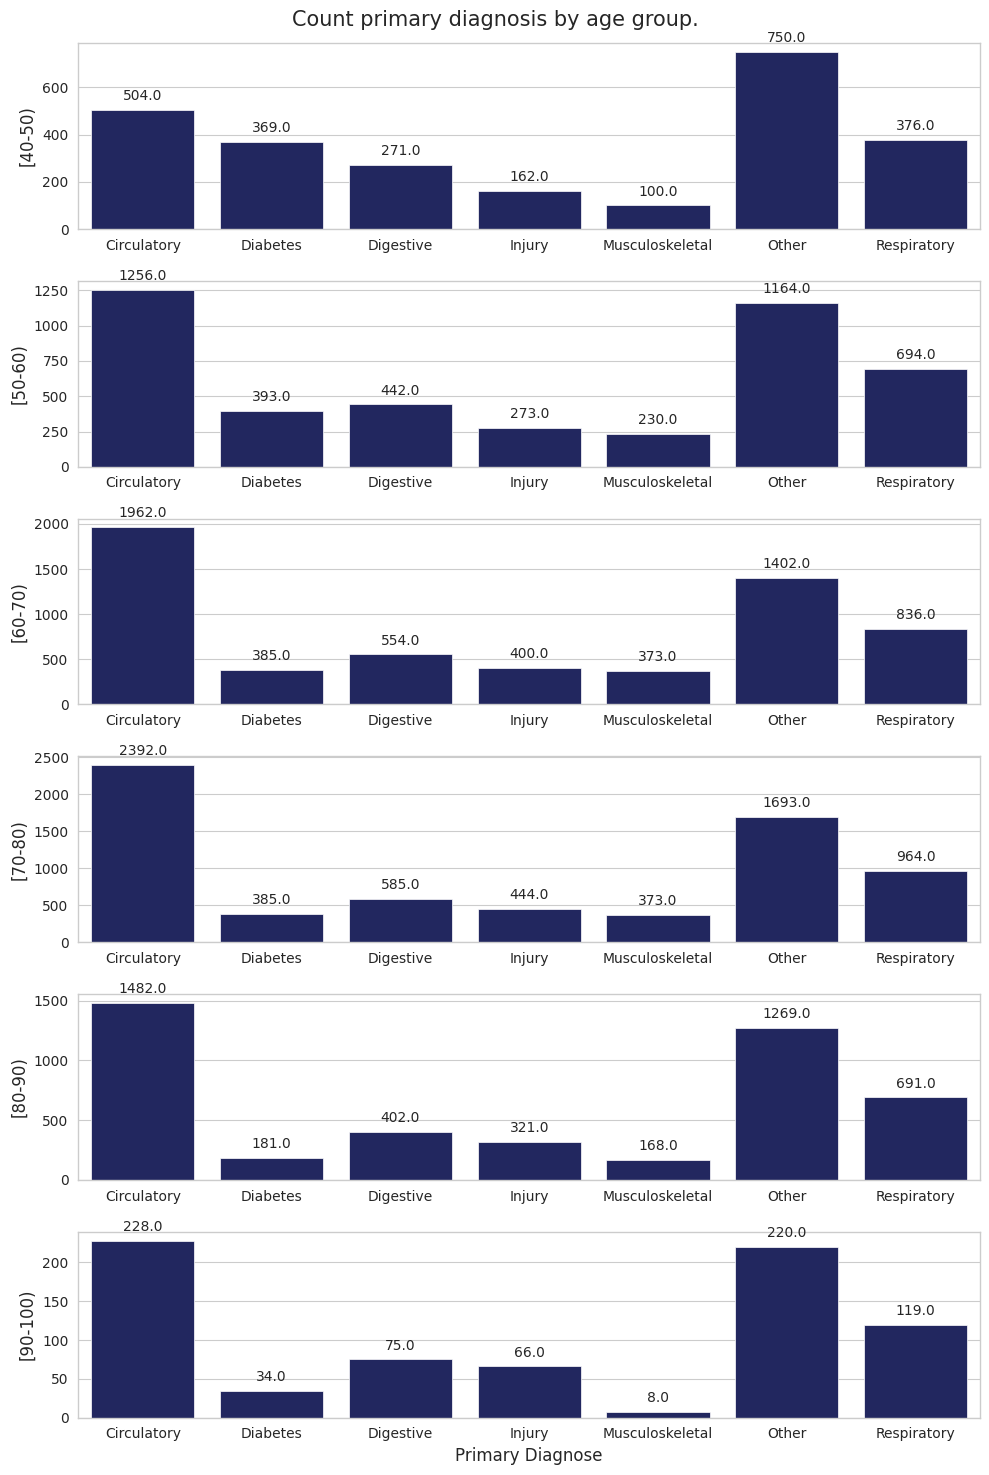

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(6, 1, figsize=(10, 15))
for i, col in enumerate(prim_diag_age.columns):
    sns.barplot(x=prim_diag_age.index, y=prim_diag_age[col], ax=axes[i], color=pallete_list[1])
    axes[i].set_xlabel(None)
    for p in axes[i].patches:
        axes[i].annotate(p.get_height(),
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 10),
                           textcoords = 'offset points')

# Add a common x-axis label for all plots
plt.xlabel("Primary Diagnose", fontsize=12)
plt.suptitle("Count primary diagnosis by age group.", fontsize=15)
plt.tight_layout()
plt.show()


* **Circulatory is the most common primary diagnosis all age group except for 40s** whose the most common diagnosis is other.
* Followed by Circulatory diagnosis,**Other takes the second place** of the most common diagnosis across all age agroups except for the 40s whose the second common diagnosis is circulatory
* **Respiratory ranks at the third** commom diagnosis across all age groups.
* **Digestive is the fourth common diagnosis above 50s age groups** and it ranks the fifth for the younger groups in this diagnosis.
* **Injury is more common  above 60s by taking the fifth common diagnosis** but for the younger groups it takes the second least common diagnosis.
* **The least common diagnosis is Musculoskeletal across all age groups.**
* Above 60s age groups shares similar ranks of the common diagnosis and the younger groups shows different frequencies of diagnosis.

### 4.2. The effect of a diabetes diagnosis on readmission rates.

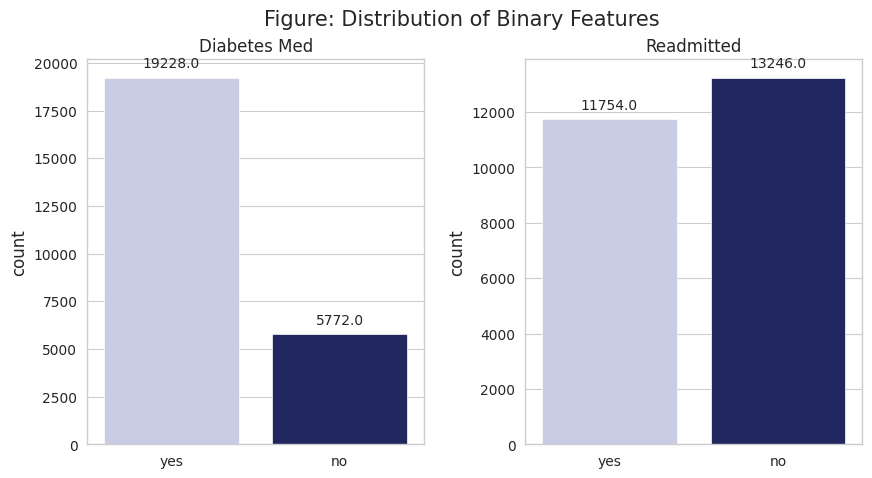

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.3})

for index, column in enumerate(["diabetes_med", "readmitted"]):
    sns.countplot(x=df[column], order=["yes", "no"], ax=ax[index], palette=pallete_list)
    for p in ax[index].patches:
        ax[index].annotate(p.get_height(),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 10),
                       textcoords = 'offset points')
    ax[index].set_title(column.replace("_", " ").title(), fontsize=12)
    ax[index].set_xlabel(None)
plt.suptitle("Figure: Distribution of Binary Features", fontsize=15)
plt.show()

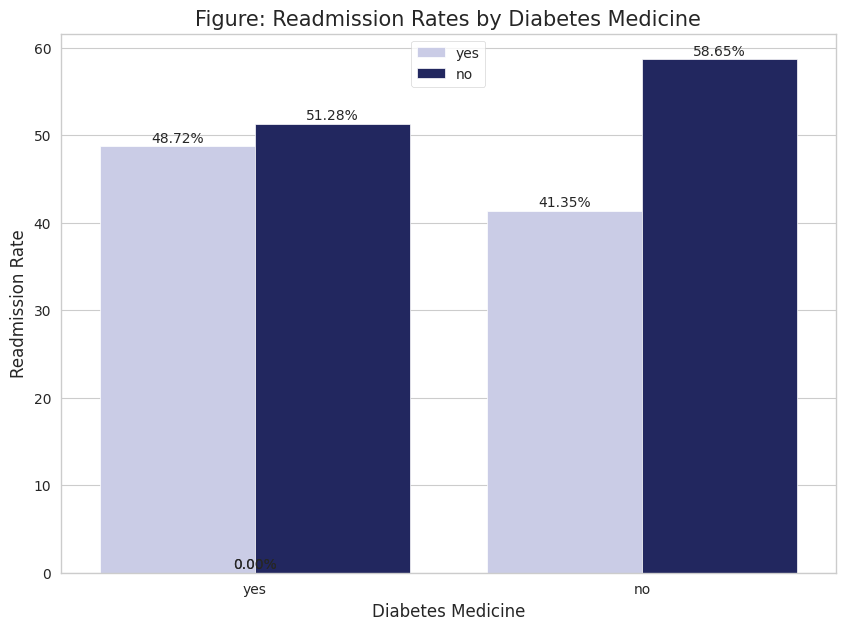

In [220]:
table_0 =df.groupby('diabetes_med')['readmitted'].value_counts(normalize=True).mul(100).round(2).reset_index(name='readmission_rate')

ax = sns.barplot(x='diabetes_med', y='readmission_rate', hue='readmitted', hue_order=['yes', 'no'], order=['yes', 'no'], data=table_0, palette=pallete_list)
for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.2f}%',
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='center',
                     xytext=(0, 6), fontsize=10,
                     textcoords='offset points')
ax.set_xlabel('Diabetes Medicine', fontsize=12)
ax.set_ylabel('Readmission Rate', rotation=90, fontsize=12)
ax.set_title('Figure: Readmission Rates by Diabetes Medicine', fontsize=15)
ax.legend( loc='upper center')
plt.show()

In [221]:
diab_readmin = pd.crosstab(index =df.diabetes_med, columns=df.readmitted)
diab_readmin

readmitted,no,yes
diabetes_med,,
no,3385,2387
yes,9861,9367


In [222]:
chi2 = chi2_contingency(diab_readmin)
chi2[1]

1.0096710996814763e-22

* Null Hypothesis(H0): there is no association between primary diagnosis of diabetes and hospital readmission rate.
* Alternative Hypothesis: primary diagnosis of diabetes has an effect on hospital readmission rates.
* Treshold: alpha = 0.05
* the P-value from diabetes and readmission rate is lower than 0.05, Which means we can reject the Null hypothesis
* Therefore, The primary diagnosis of diabetes affects hospital readmission rates.

### 4.3. Groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission

In [223]:
categorical_features = [i for i in df.columns if df[i].dtypes == 'object']
catset_preprocessed = pd.get_dummies(df[categorical_features], drop_first=True)

numeric_features = [i for i in df.columns if df[i].dtypes != 'object']
numset_preprocessed = df[numeric_features]
data_scaled = pd.concat([numset_preprocessed, catset_preprocessed ], axis=1)
data_scaled

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,age_[50-60),age_[60-70),age_[70-80),...,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal,change_yes,diabetes_med_yes,readmitted_yes
0,8,72,1,18,2,0,0,False,False,True,...,False,True,False,True,False,True,False,False,True,False
1,3,34,2,13,0,0,0,False,False,True,...,False,True,False,True,False,True,False,False,True,False
2,5,45,0,18,0,0,0,True,False,False,...,False,False,False,True,False,True,False,True,True,True
3,2,36,0,12,1,0,0,False,False,True,...,False,False,False,True,False,True,False,True,True,True
4,1,42,0,7,0,0,0,False,True,False,...,False,False,True,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,77,1,30,0,0,0,False,False,False,...,False,False,False,True,False,False,True,False,False,True
24996,2,66,0,24,0,0,0,False,False,False,...,False,True,False,True,False,False,False,True,True,True
24997,5,12,0,6,0,1,0,False,False,True,...,False,True,False,False,True,True,False,False,False,True
24998,2,61,3,15,0,0,0,False,False,True,...,False,True,False,True,False,True,False,True,True,False


In [224]:
SEED = 3

In [225]:
y = data_scaled.readmitted_yes
X = data_scaled.drop("readmitted_yes", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
print(X_train.shape, X_test.shape)

(17500, 45) (7500, 45)


In [226]:
# change some columns names to prevent Json error
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

In [227]:
Knclass = KNeighborsClassifier()
logreg = LogisticRegression(random_state=SEED)
rnforest = RandomForestClassifier(random_state=SEED)
lgb = LGBMClassifier()
models = {'KNeighborsClassifier':Knclass,
         'LogisticRegression':logreg,
         'RandomForestClassifier': rnforest,
         'LightGBM': lgb}


In [228]:
def model_train_metrics(models):
    """
    make a table for metrics comparing diverse models
    metrics are:
    accuracy, precision, recalls, F1 score of train and test set
    """
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_precs = []
    train_recs = []


    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_precs = []
    test_recs = []

    fprss = []
    tprss = []

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        y_prob_test = model.predict_proba(X_test)[:, 1]
        y_prob_train = model.predict_proba(X_train)[:, 1]

        train_precisions, train_recalls, threshold = precision_recall_curve(y_train, y_prob_train)
        test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_prob_test)

        train_accs.append(accuracy_score(y_train, y_pred_train))
        train_f1s.append(f1_score(y_train,  y_pred_train))
        train_roc_aucs.append(roc_auc_score(y_train, y_prob_train))
        train_precs.append(precision_score(y_train, y_pred_train))
        train_recs.append(recall_score(y_train, y_pred_train))

        test_accs.append(accuracy_score(y_test, y_pred_test))
        test_f1s.append(f1_score(y_test, y_pred_test))
        test_roc_aucs.append(roc_auc_score(y_test, y_prob_test))
        test_precs.append(precision_score(y_test, y_pred_test))
        test_recs.append(recall_score(y_test, y_pred_test))


    train_metrics = pd.DataFrame(
    {'model': models.keys(),
    'accuracy': train_accs,
    'f1_score': train_f1s,
    'roc_auc': train_roc_aucs,
    'precision': train_precs,
    'recall': train_recs})

    test_metrics =  pd.DataFrame(
    {'model': models.keys(),
    'accuracy': test_accs,
    'f1_score': test_f1s,
    'roc_auc': test_roc_aucs,
    'precision': test_precs,
    'recall': test_recs})


    train_test_metrics = train_metrics.merge(test_metrics,
                                            on='model',
                                            how='left',
                                            suffixes=('_train', '_test'))

    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                            'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test'])



    return train_test_metrics.set_index('model').transpose()



train_test_metrics = model_train_metrics(models)

[LightGBM] [Info] Number of positive: 8280, number of negative: 9220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 17500, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473143 -> initscore=-0.107532
[LightGBM] [Info] Start training from score -0.107532


In [229]:
print('Table: Base models metrics table.')
train_test_metrics.style.background_gradient(cmap='Blues')

Table: Base models metrics table.


model,KNeighborsClassifier,LogisticRegression,RandomForestClassifier,LightGBM
accuracy_train,0.705486,0.609371,1.000000,0.694343
accuracy_test,0.552800,0.616933,0.611867,0.622133
f1_score_train,0.676338,0.502692,1.000000,0.648762
f1_score_test,0.498054,0.499913,0.549451,0.554962
roc_auc_train,0.770322,0.646009,1.000000,0.770503
roc_auc_test,0.565251,0.655071,0.643927,0.661508
precision_train,0.704474,0.632089,1.000000,0.710894
precision_test,0.518703,0.632321,0.594242,0.610574
recall_train,0.650362,0.417271,1.000000,0.596618
recall_test,0.478987,0.413356,0.510938,0.508636


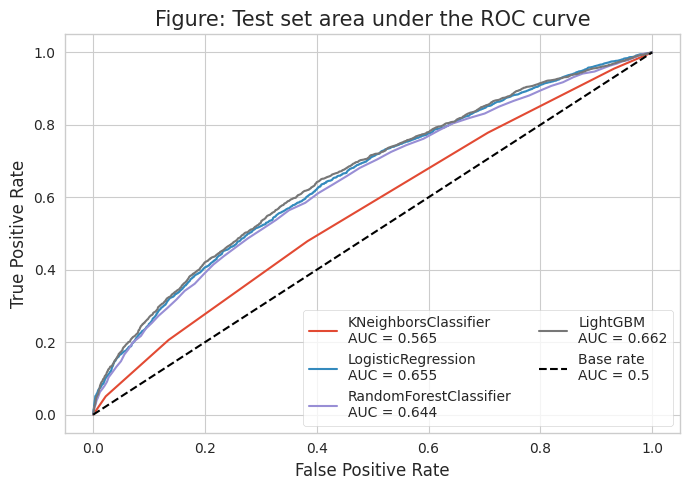

In [230]:
def Plot_Roc_curves(models):
    """
    making ROC-AUC Curve
    """
    fprss = []
    tprss = []
    precs = []
    recs = []
    roc_aucs = []

    for name, model in models.items():
        y_probs = model.predict_proba(X_test)[:, 1]
        fprs, tprs, _ = roc_curve(y_test, y_probs)
        precisions, recalls, _ = precision_recall_curve(y_test, y_probs)

        fprss.append(fprs)
        tprss.append(tprs)
        precs.append(precisions)
        recs.append(recalls)
        roc_aucs.append(roc_auc_score(y_test, y_probs))

    plt.figure(figsize=(7, 5))

    for i in range(len(fprss)):
        model_name = list(models.keys())[i]
        label_model = f"{model_name}\nAUC = {roc_aucs[i]:.3f}"
        sns.lineplot(x=fprss[i], y=tprss[i], label=label_model)

    # Plot the base rate line
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', label='Base rate\nAUC = 0.5', color='black')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Test Set Area Under the ROC Curve', fontsize=15)
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0), ncol=2, frameon=True)

    # Show the plot
    plt.title('Figure: Test set area under the ROC curve', fontsize=15)
    plt.tight_layout()
    plt.show()


Plot_Roc_curves(models)


In [231]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply Random Search to fine better model parameters
dists = {'learning_rate': [0.05], 'num_leaves':[70], 'max_depth':[3, 5, 10, 15]}
rndsearch = RandomizedSearchCV(lgb, param_distributions=dists, cv=5, verbose = 1, n_iter = 3000, random_state=0)
rndsearch.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 6624, number of negative: 7376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473143 -> initscore=-0.107532
[LightGBM] [Info] Start training from score -0.107532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=3000,
                   param_distributions={'learning_rate': [0.05],
                                        'max_depth': [3, 5, 10, 15],
                                        'num_leaves': [70]},
                   random_state=0, verbose=1)

Accuracy: 0.62


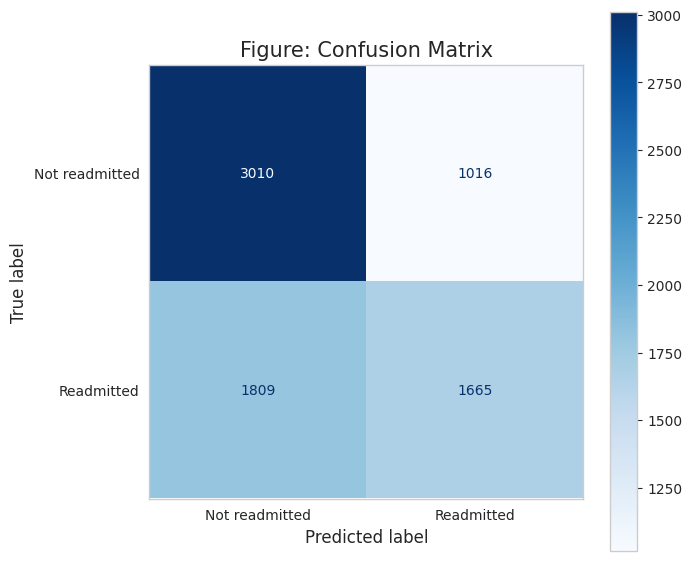

In [232]:
best_grid = rndsearch.best_estimator_
pred = best_grid.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print('Accuracy: {:.2f}'.format(accuracy))

fig, ax = plt.subplots(figsize=(7,7))
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                          display_labels=['Not readmitted', 'Readmitted'])
cm.plot(cmap='Blues', ax=ax)
plt.grid(False)
plt.title("Figure: Confusion Matrix", fontsize=15)
plt.show()

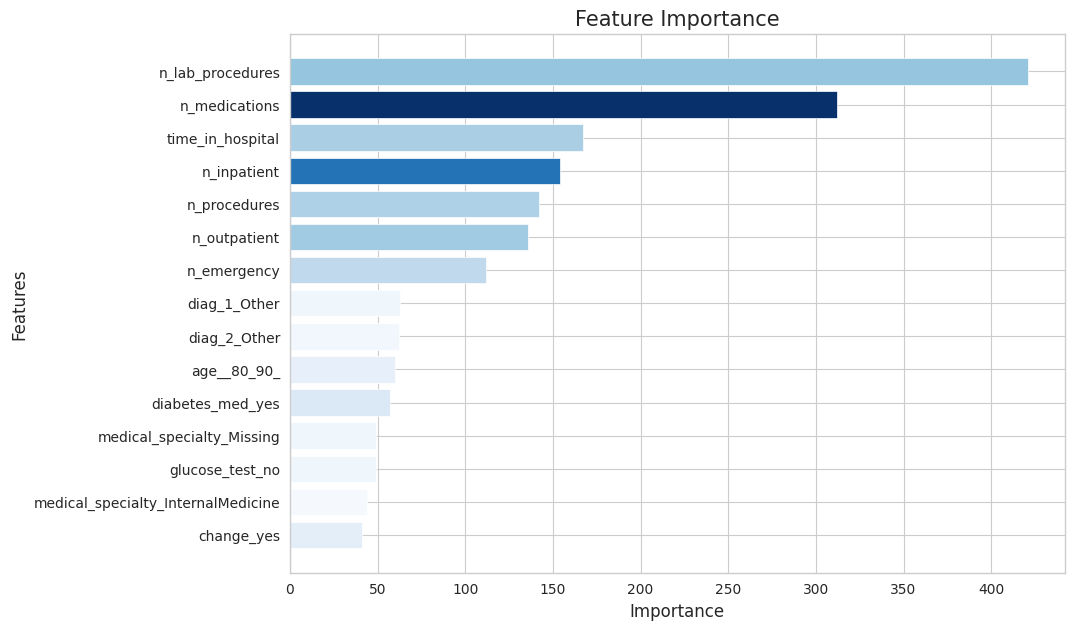

In [233]:
plt.rcParams["figure.figsize"] = (10, 7)

# Extract feature importances and feature names
feature_importances = best_grid.booster_.feature_importance(importance_type='split')
feature_names = best_grid.booster_.feature_name()

# Create a DataFrame for feature importances and select 15 features
importances_model = pd.DataFrame(feature_importances, index=feature_names, columns=["importance"]).sort_values(by='importance', ascending=False)[:15]

# Normalize the feature importances for color mapping
normalized_importances = (feature_importances - feature_importances.min()) / (
    feature_importances.max() - feature_importances.min()
)

cmap = plt.cm.Blues
colors = cmap(normalized_importances)

# Plot the feature importances with a custom color palette
plt.barh(importances_model.index, importances_model["importance"], color=colors)

plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance", fontsize=15)
plt.gca().invert_yaxis()

plt.show()


We can conclue that the features that the most affect our model are:
- **n_lab_procedures** - number of laboratory procedures performed during the hospital stay
- **n_medications** - number of medications administered during the hospital stay
- **time_in_hospital** - days (from 1 to 14)

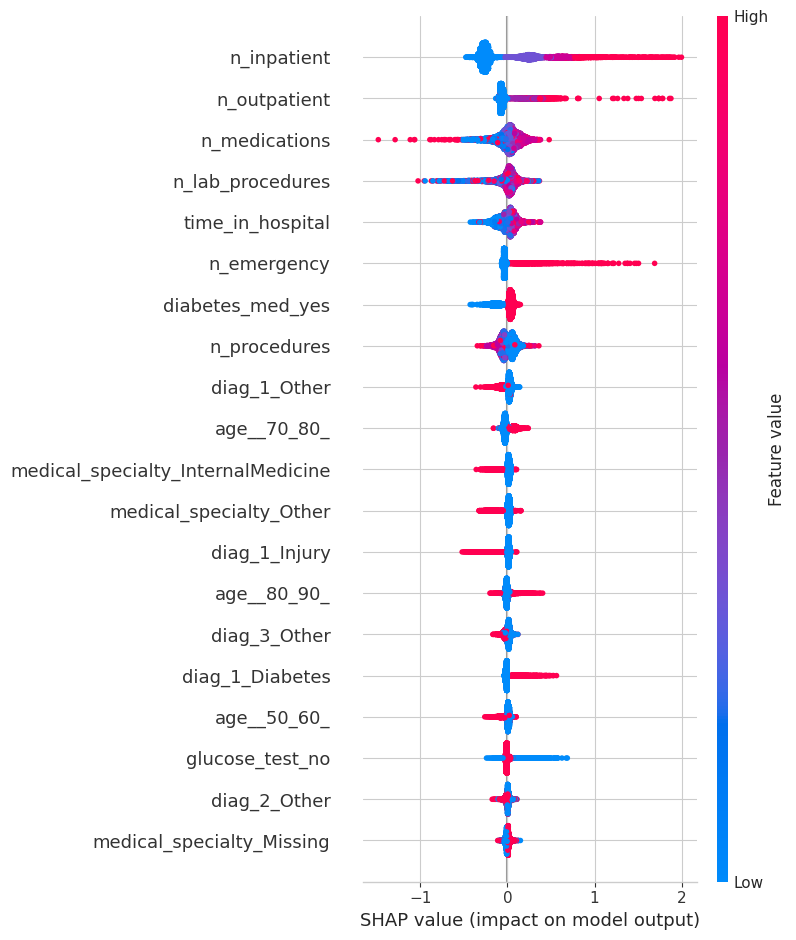

In [234]:
import shap
# compute SHAP values
explainer = shap.Explainer(lgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


The SHAP summary plot offers insight to the contribution of the features to a machine learning model's predictions.
- n_inpatient, n_outpatient and n_emergecy are the most important features
- high value(red) increase the SHAP value, contributing positive to the prediction
- low value(blue) tend to decrease the SHAP value, moving prediction in the opposite direction
- n_inpatient is the most influential. High value push the prediction higher while low values lower it.
- n_medications and n_lab_procedures are giving significant impact but a slightly lesser degree
- diag_3_missing data decreases predictions
- glucose_test_no has a strong, narrow impact on predictions, typically in one direction (negative SHAP values)
- age_90-100 has a relatively large and consistent negative impact on the model's prediction

## 5. Further consideration and visualization

In [235]:
df.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


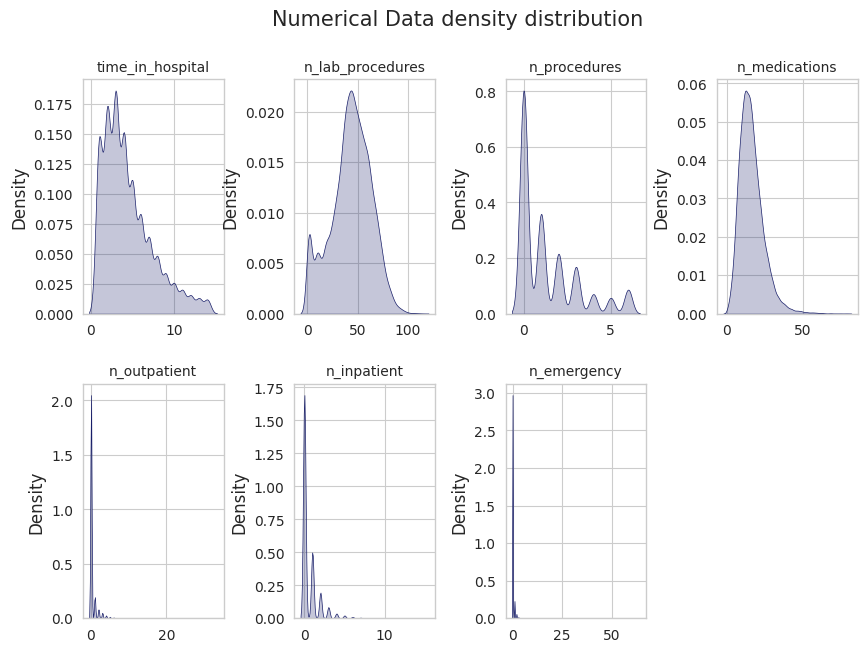

In [236]:
numeric_df = df.select_dtypes(exclude=object)

num_col_count = len(numeric_df.columns)

nrows = 2
ncols= int(np.ceil(num_col_count/2))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
axes[-1, -1].remove()
for ax, col in zip(axes.flatten(), numeric_df.columns):
    sns.kdeplot(numeric_df[col], ax=ax, fill=True, color=pallete_list[1])
    ax.set_title(col, fontsize=10)
    ax.set_xlabel(None)

plt.suptitle('Numerical Data density distribution', fontsize=15)
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()


The total number of outliers is: 11181

Number of outliers in each columns:
time_in_hospital     580
n_lab_procedures      33
n_procedures        1227
n_medications        844
n_outpatient        4141
n_inpatient         1628
n_emergency         2728
dtype: int64


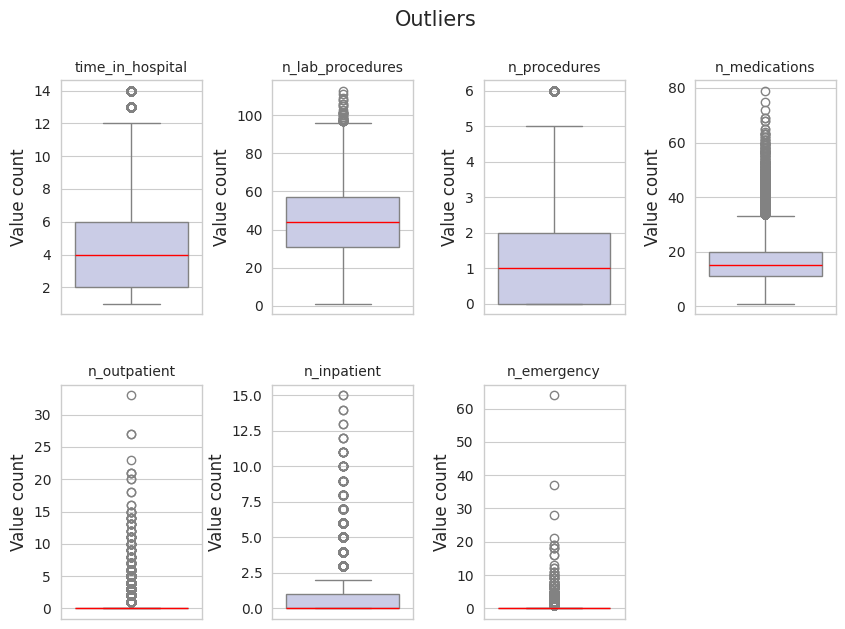

In [237]:
# Inspecting outliers
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = numeric_df[(numeric_df < lower_bound) | (numeric_df > upper_bound)]

print(
    f"The total number of outliers is: {outliers.count().sum()}\n\nNumber of outliers in each columns:\n{outliers.count()}")

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
axes[-1, -1].remove()
for ax, col in zip(axes.flatten(), numeric_df.columns):
    sns.boxplot(numeric_df[col], medianprops={'color':'red'}, ax=ax, color=pallete_list[0])
    ax.set_title(col, fontsize=10)
    ax.set_xlabel(None)
    ax.set_ylabel('Value count')
    ax.set_xticks([])

plt.suptitle('Outliers', fontsize=15)
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()


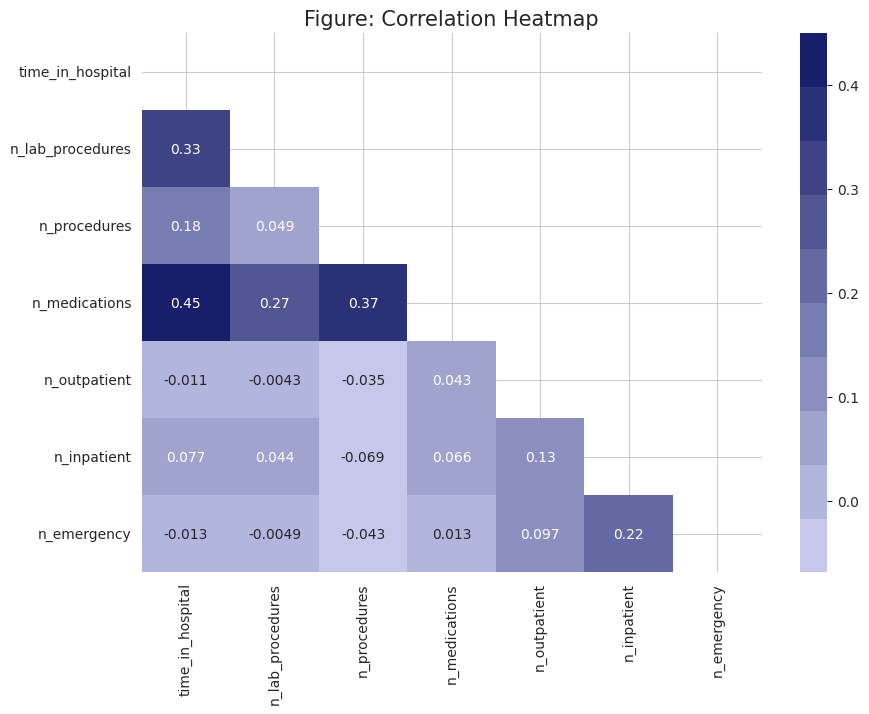

In [238]:
sns.heatmap(numeric_df.corr(), annot=True, mask=np.triu(numeric_df.corr()), cmap=palette)
plt.title('Figure: Correlation Heatmap', fontsize=15)
plt.show()

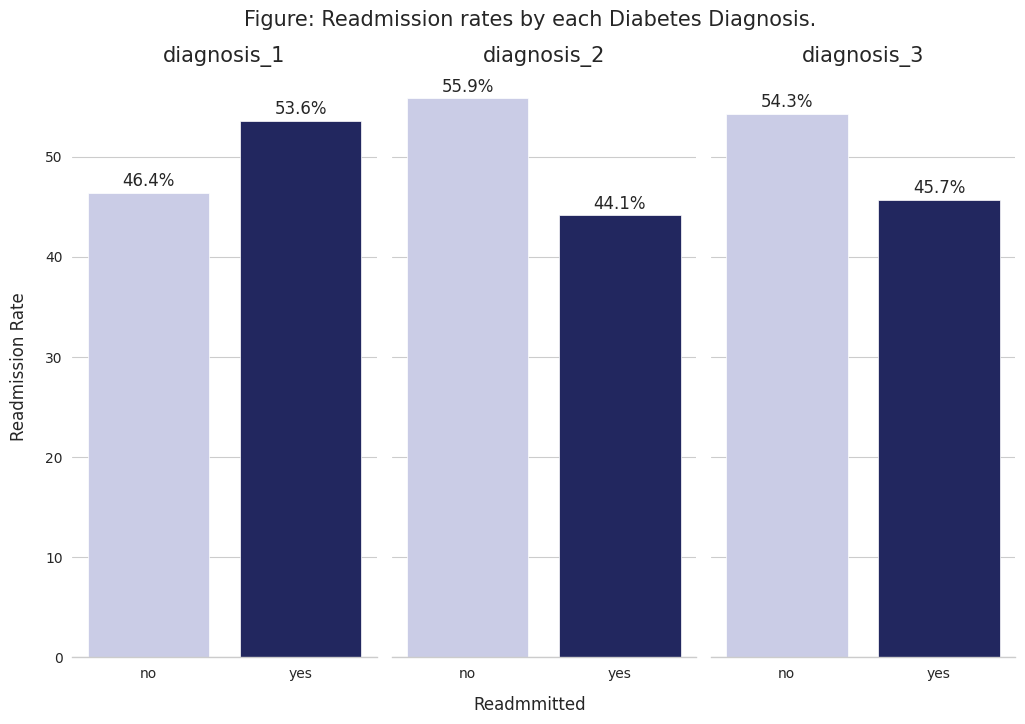

In [239]:
df_diag1 = df[df['diag_1']=='Diabetes']
table_1 = (df_diag1['readmitted']
           .value_counts(normalize=True)
           .mul(100)
           .round(2)
           .reset_index(name='readmission_rate')
           .rename(columns={'index': 'readmitted'})
           )

df_diag2 = df[df['diag_2']=='Diabetes']
table_2 = (df_diag2['readmitted']
           .value_counts(normalize=True)
           .mul(100)
           .round(2)
           .reset_index(name='readmission_rate')
           .rename(columns={'index': 'readmitted'})
           )

df_diag3 = df[df['diag_3']=='Diabetes']
table_3 = (df_diag3['readmitted']
           .value_counts(normalize=True)
           .mul(100)
           .round(2)
           .reset_index(name='readmission_rate')
           .rename(columns={'index': 'readmitted'})
           )

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)



for i, table in enumerate([table_1,table_2, table_3]):
    sns.barplot(x='readmitted', y='readmission_rate', data = table.sort_values('readmitted'), ax=axes[i], palette=pallete_list)
    axes[i].set_title(f'diagnosis_{i+1}',  fontsize=15)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)
    for bar in axes[i].patches:
        height = bar.get_height()
        axes[i].annotate(f"{height:.1f}%", xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2), textcoords='offset points',
                    ha='center', va='bottom', fontsize=12)
fig.text(0.5, -0.02, 'Readmmitted', ha='center', fontsize=12)
fig.text(-0.02, 0.47, 'Readmission Rate', va='center', fontsize=12, rotation=90)

plt.suptitle('Figure: Readmission rates by each Diabetes Diagnosis.', fontsize=15)
sns.despine(left=True)
plt.tight_layout()

plt.show()

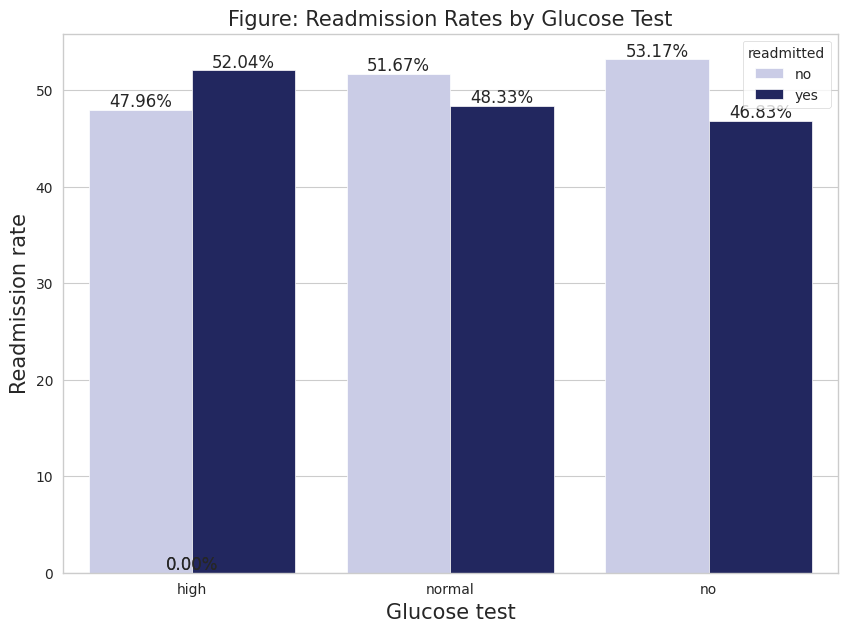

In [240]:
table_4 = (df.groupby('glucose_test')['readmitted'].value_counts(normalize=True)
           .mul(100).round(2)
           .reset_index(name='readmission_rate'))

ax = sns.barplot(x='glucose_test', y='readmission_rate', hue='readmitted',
           order=['high', 'normal','no'], hue_order=['no', 'yes'], data=table_4,  palette=pallete_list)

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.2f}%',
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='center',
                     xytext=(0, 6), fontsize=12,
                     textcoords='offset points')
ax.set_xlabel('Glucose test', fontsize=15)
ax.set_ylabel('Readmission rate', fontsize=15, rotation=90)
ax.set_title('Figure: Readmission Rates by Glucose Test', fontsize=15)

plt.show()

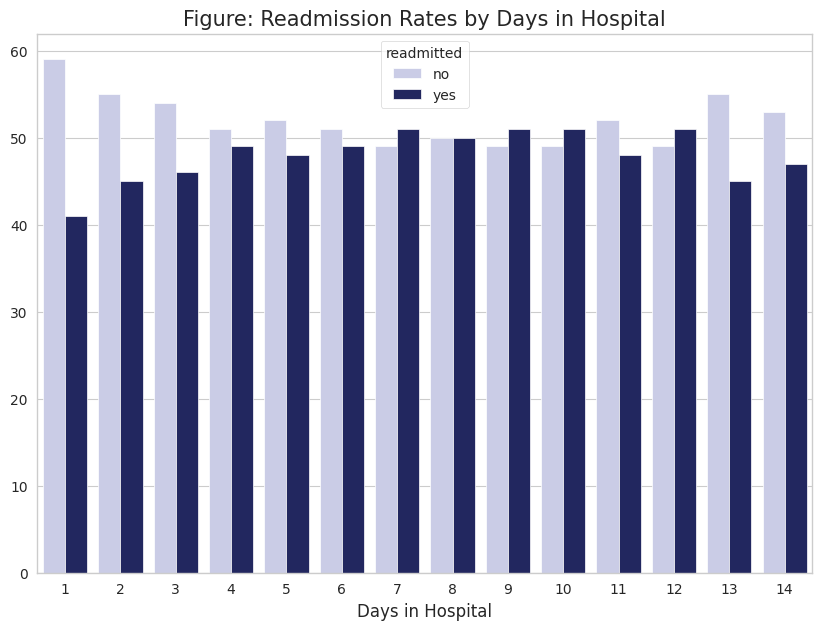

In [241]:
table_5 = (df
           .groupby('time_in_hospital')['readmitted']
           .value_counts(normalize=True)
           .mul(100)
           .round()
           .reset_index(name='readmission_rate')
           )

ax = sns.barplot(x='time_in_hospital', y='readmission_rate', hue='readmitted',
           hue_order=['no', 'yes'], data=table_5,  palette=pallete_list)
ax.set_ylabel(None)
ax.set_xlabel('Days in Hospital', fontsize=12)
ax.set_title('Figure: Readmission Rates by Days in Hospital', fontsize=15)
plt.show()

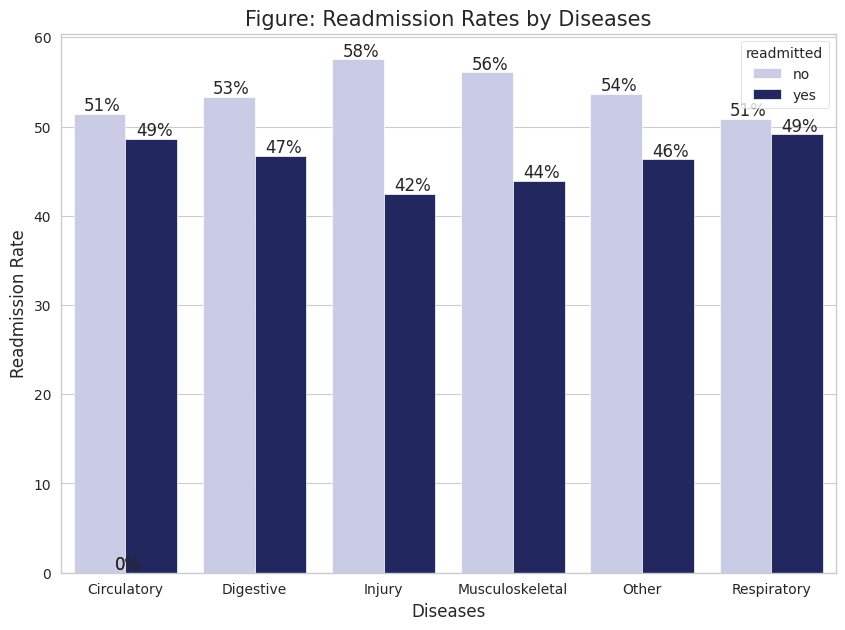

In [242]:
other_diag = df[df.apply(lambda x: 'Diabetes' not in x.values, axis=1)]
other_diag = (other_diag[['readmitted', 'diag_1', 'diag_2', 'diag_3']].melt(id_vars='readmitted', var_name='diag', value_name='diseases').drop('diag', axis=1))

other_readmission = (other_diag.
                     groupby('diseases')
                     .value_counts(normalize=True)
                     .mul(100)
                     .round(2)
                     .reset_index(name='readmission_rate'))
other_readmission = other_readmission[other_readmission['diseases'] !='Missing']

ax = sns.barplot(x='diseases', y='readmission_rate', hue='readmitted', hue_order=['no','yes'], data=other_readmission, palette=pallete_list)

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}%',
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='center',
                     xytext=(2, 6), fontsize=12,
                     textcoords='offset points')
ax.set_xlabel('Diseases')
ax.set_ylabel('Readmission Rate')
ax.set_title('Figure: Readmission Rates by Diseases', fontsize=15)

plt.show()